<a href="https://colab.research.google.com/github/kyxyxn/Telemedicine/blob/main/%5Bmental%5D_2_visits_and_rough_DID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd   
from functools import reduce
from scipy.stats import entropy

In [ ]:
rootPath ='/content/drive/MyDrive/ASU/CIS791_Chen_Final/uds-data/'
filenames_uds = [rootPath+'UDS-2014-Full-Dataset.xlsx',
                 rootPath+'UDS-2015-Full-Dataset.xlsx',
                 rootPath+'UDS-2016-Full-Dataset.xlsx',
                 rootPath+'UDS-2017-Full-Dataset.xlsx',
                 rootPath+'UDS-2018-Full-Dataset.xlsx',
                 rootPath+'UDS-2019-Full-Dataset.xlsx',
                 rootPath+'UDS-2020-Full-Dataset.xlsx']

In [ ]:
df = pd.read_csv(rootPath+'samples_hc.csv')

### Get HC mental visit data

In [ ]:
visit_df = visit_info(filenames_uds)
visit_df.columns=['Grant Number', 'alcohol_num_visits', 'alcohol_num_patients',
                  'tobacco_num_visits', 'tobacco_num_patients',
                  'depression_num_visits', 'depression_num_patients',
                  'anxiety_num_visits', 'anxiety_num_patients', 
                  'attention_num_visits', 'attention_num_patients',
                  'other_num_visits', 'other_num_patients', 'year']
visit_df = visit_df[visit_df['Grant Number']!='GrantNumber'].reset_index(drop=True)
visit_df = visit_df.replace(to_replace={'-':np.nan})

# If Num visits = 0, num_patients=0
visit_df.loc[visit_df['alcohol_num_visits'].isna(),'alcohol_num_patients']=0
# Fill 0
## reporting of all diagnoses (not just primary diagnosis) and services rendered during all UDS-countable visits are required. 
visit_df = visit_df.fillna(0)

In [ ]:
# Total mental visits, patients
num_visits_col = visit_df.columns[1::2][:-1]
num_patients_col = visit_df.columns[::2][1:]

num_visits_df = visit_df[num_visits_col].sum(axis=1).to_frame(name='total_mental_visits')
num_patients_df = visit_df[num_patients_col].sum(axis=1).to_frame(name='total_mental_patients')

visit_df = pd.concat([visit_df, num_visits_df, num_patients_df], axis=1)

### Try DID

In [ ]:
# Treated @ 2017
set1 = set(df[(df['year']==2017)&(df['mental_telehealth']==1)&(df['consistency']==1)]['Grant Number'].values) # treated at 2017
set2 = set(df[(df['year']==2016)&(df['mental_telehealth']==0)&(df['consistency']==1)]['Grant Number'].values) # untreated at 2016
treated_2017 = list(set1.intersection(set2))
print("{} HCs were treated @ 2017".format(len(treated_2017)))

# Treated @ 2018
set1 = set(df[(df['year']==2018)&(df['mental_telehealth']==1)&(df['consistency']==1)]['Grant Number'].values) # treated at 2018
set2 = set(df[(df['year']==2017)&(df['mental_telehealth']==0)&(df['consistency']==1)]['Grant Number'].values) # untreated at 2017
treated_2018 = list(set1.intersection(set2))
print("{} HCs were treated @ 2018".format(len(treated_2018)))

# Treated @ 2019
set1 = set(df[(df['year']==2019)&(df['mental_telehealth']==1)&(df['consistency']==1)]['Grant Number'].values) # treated at 2019
set2 = set(df[(df['year']==2018)&(df['mental_telehealth']==0)&(df['consistency']==1)]['Grant Number'].values) # untreated at 2018
treated_2019 = list(set1.intersection(set2))
print("{} HCs were treated @ 2019".format(len(treated_2019)))

# Untreated until 2019
control = list(set(df[(df['year']==2020)&(df['mental_telehealth']==0)&(df['consistency']==1)]['Grant Number'].values)) # treated at 2019
print("{} HCs were never treated".format(len(control)))

26 HCs were treated @ 2017
43 HCs were treated @ 2018
73 HCs were treated @ 2019
32 HCs were never treated


In [ ]:
visit_df.loc[:, 'year'] = visit_df.loc[:, 'year'].astype(int)

In [ ]:
tg_bf_visits = visit_df[(visit_df['Grant Number'].isin(treated_2017))&(visit_df['year']<2017)].groupby(['year']).mean()['total_mental_visits'].values.tolist()
tg_aft_visits = visit_df[(visit_df['Grant Number'].isin(treated_2017))&(visit_df['year']>=2017)].groupby(['year']).mean()['total_mental_visits'].values.tolist()
tg_visits = tg_bf_visits+tg_aft_visits

tg_bf_patients = visit_df[(visit_df['Grant Number'].isin(treated_2017))&(visit_df['year']<2017)].groupby(['year']).mean()['total_mental_patients'].values.tolist()
tg_aft_patients = visit_df[(visit_df['Grant Number'].isin(treated_2017))&(visit_df['year']>=2017)].groupby(['year']).mean()['total_mental_patients'].values.tolist()
tg_patients = tg_bf_patients+tg_aft_patients

cg_bf_visits = visit_df[(visit_df['Grant Number'].isin(control))&(visit_df['year']<2017)].groupby(['year']).mean()['total_mental_visits'].values.tolist()
cg_aft_visits = visit_df[(visit_df['Grant Number'].isin(control))&(visit_df['year']>=2017)].groupby(['year']).mean()['total_mental_visits'].values.tolist()
cg_visits = cg_bf_visits+cg_aft_visits

cg_bf_patients = visit_df[(visit_df['Grant Number'].isin(control))&(visit_df['year']<2017)].groupby(['year']).mean()['total_mental_patients'].values.tolist()
cg_aft_patients = visit_df[(visit_df['Grant Number'].isin(control))&(visit_df['year']>=2017)].groupby(['year']).mean()['total_mental_patients'].values.tolist()
cg_patients = cg_bf_patients+cg_aft_patients


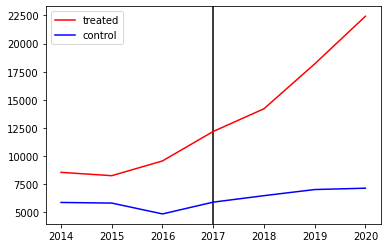

In [ ]:
import matplotlib.pyplot as plt

X = list(range(2014, 2021))
y1 = tg_visits
y2 = cg_visits

plt.axvline(x=2017, color='black')

plt.plot(X, y1, color='red', label='treated')
plt.plot(X, y2, color='blue', label='control')
plt.legend()
plt.show()

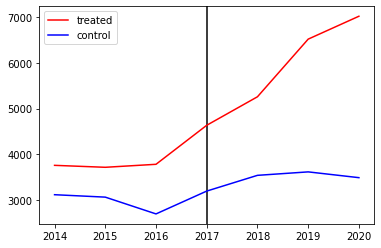

In [ ]:
import matplotlib.pyplot as plt

X = list(range(2014, 2021))
y1 = tg_patients
y2 = cg_patients

plt.axvline(x=2017, color='black')

plt.plot(X, y1, color='red', label='treated')
plt.plot(X, y2, color='blue', label='control')
plt.legend()

plt.show()

In [ ]:
total_mental_visits      12181.307692
total_mental_patients     4632.961538
dtype: float64

In [ ]:
# CGs that are similar to TGs
control2 = visit_df[(visit_df['Grant Number'].isin(control))&(visit_df['year']==2017)].sort_values(by=['total_mental_visits'], ascending=False).iloc[:10]['Grant Number'].values.tolist()
# New values
cg_bf_visits = visit_df[(visit_df['Grant Number'].isin(control2))&(visit_df['year']<2017)].groupby(['year']).mean()['total_mental_visits'].values.tolist()
cg_aft_visits = visit_df[(visit_df['Grant Number'].isin(control2))&(visit_df['year']>=2017)].groupby(['year']).mean()['total_mental_visits'].values.tolist()
cg_visits = cg_bf_visits+cg_aft_visits

cg_bf_patients = visit_df[(visit_df['Grant Number'].isin(control2))&(visit_df['year']<2017)].groupby(['year']).mean()['total_mental_patients'].values.tolist()
cg_aft_patients = visit_df[(visit_df['Grant Number'].isin(control2))&(visit_df['year']>=2017)].groupby(['year']).mean()['total_mental_patients'].values.tolist()
cg_patients = cg_bf_patients+cg_aft_patients


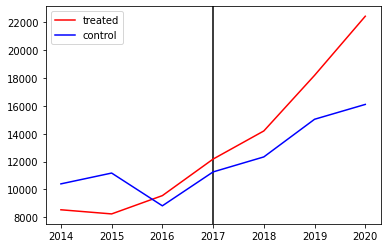

In [ ]:
import matplotlib.pyplot as plt

X = list(range(2014, 2021))
y1 = tg_visits
y2 = cg_visits

plt.axvline(x=2017, color='black')

plt.plot(X, y1, color='red', label='treated')
plt.plot(X, y2, color='blue', label='control')
plt.legend()
plt.show()

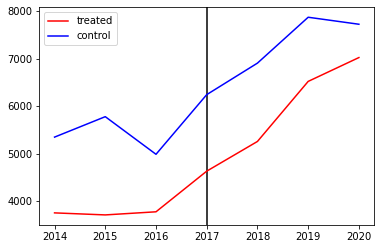

In [ ]:
import matplotlib.pyplot as plt

X = list(range(2014, 2021))
y1 = tg_patients
y2 = cg_patients

plt.axvline(x=2017, color='black')

plt.plot(X, y1, color='red', label='treated')
plt.plot(X, y2, color='blue', label='control')
plt.legend()

plt.show()